In [1]:
import numpy as np

In [2]:
import tensorflow as tf
import tensorflow.distributions as tfd
from tensorflow.distributions import Normal
from tensorflow.nn import softmax
from tensorflow import exp, log, ones, zeros

In [3]:
tf.enable_eager_execution()

In [4]:
import matplotlib.pyplot as pl
%matplotlib inline

## Generate Data

In [5]:
π_true = tf.constant([0.4, 0.6])
μ_true = tf.constant([-1., 2.])
σ_true = tf.constant([1/2, 1/3])

In [6]:
def generate_sample(π, μ, σ, N):
    x = tfd.Normal(loc = μ, scale = σ).sample(N)
    y = tfd.Categorical(probs = π).sample(N)
    z = tf.gather_nd(x, indices = tf.stack([tf.range(N), y], axis = -1))
    return z

z = generate_sample(π_true, μ_true, σ_true, N = 500)

In [7]:
def plot_distr(π, μ, σ, interval, **kwargs):
    xxx = np.linspace(*interval, 200, dtype = np.float32)
    yyy = tf.reduce_sum(
        π * tfd.Normal(loc = μ[None, :], scale = σ[None, :]).prob(xxx[:, None]),
        axis = -1
    )
    pl.plot(xxx, yyy, **kwargs)

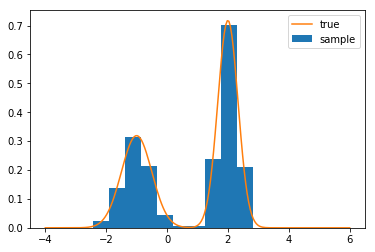

In [8]:
pl.hist(z, density=True, label = "sample");
plot_distr(π_true, μ_true, σ_true, interval = [-4, 6], label = "true")
pl.legend()

## Model parametrization

Natural model parameters are three vectors of lenght $K$: $\pi, \mu, \sigma$ - probas of the clusters, their locations and scale parameters.

We parametrize it slightly differently by $\theta := (\rho, \mu, \beta)$ where
* $\beta = \log(\sigma^2)\quad \text{i.e.}\quad \sigma = e^{\beta/2}$
* $ \pi_j = \frac{\exp(\rho_j)}{\sum_k \exp(\rho_j)}$ or `pi = softmax(rho)`

In [9]:
# change of parametrization
def get_πμσ(θ):
    ρ, μ, β = θ
    π = softmax(ρ)
    σ = exp(β / 2)
    return π, μ, σ 

## Model prior

In [10]:
# model prior
K = 2
ρ_prior = Normal(loc = zeros(K), scale = ones(K))
μ_prior = Normal(loc = zeros(K), scale = ones(K))
β_prior = Normal(loc = zeros(K), scale = ones(K))

def θ_log_prior(θ) -> "scalar":
    ρ, μ, β = θ
    return tf.reduce_sum(
        ρ_prior.log_prob(ρ) + μ_prior.log_prob(μ) + β_prior.log_prob(β)
    )

## EM-algorithm
#### Choose starting value of $\theta$

In [67]:
# Choose starting value of model parameters
ρ = tf.Variable(ρ_prior.sample(), name = "rho")
μ = tf.Variable(μ_prior.sample(), name = "mu")
β = tf.Variable(β_prior.sample(), name = "beta")

θ = ρ, μ, β

### E-step
* **E-step:** for fixed $\theta$ and each $i$ calculate "posterior density of $Y_i$ given $z_i$, $\theta$":
$$ P_i(y) := \P(Y_i = y\mid \theta, z_i) \;\propto\; \P(Y_i = y\mid \theta) \cdot \P(z_i\mid \theta, Y_i = y)\; =\; \pi_y \cdot \P(z_i\mid \theta, Y_i = y)$$
We calculate it as follows:
* `lhds[i, y] :=`$\P(z_i\mid \theta, Y_i = y)$ = `Norm(loc=mu[y], scale = sigma[y]).prob(z[i])`
* `P[i, y] := pi[y] * a[i, y]` 
* and then normalize `P` wrt `y`-index.

In [68]:
def get_lhds(z, θ) -> "Tensor of shape (N, K)":
    """return `lhds[i, y] = \P(z_i| Y_i = y, θ)$"""
    π, μ, σ = get_πμσ(θ)  
    return Normal(loc = μ[None, :], scale = σ[None, :]).prob(z[:, None])

In [69]:
def E_step(z, θ) -> "Tensor of shape (N, K)":
    """Return 'posterior' distribution `P(y)` on `Y` given `z`, `θ`."""
    π, μ, σ = get_πμσ(θ)  
    P = π * get_lhds(z, θ)
    P = P / tf.reduce_sum(P, axis=-1, keepdims=True)
    return P

P = E_step(z, θ)
P.shape

TensorShape([Dimension(500), Dimension(2)])

### M-Step
$\newcommand{\argmax}[1]{\underset{#1}{\mathrm{argmax}}}$
* **M-step:** Now fix all $P_i$ and maximize wrt $\theta$ the following 
$$\log\P(\theta) + \sum_i\sum_y P_i(y)\cdot\log\P(z_i, Y_i = y| \theta) = \log\P(\theta) + \sum_i\sum_y P_i(y)\big[ \log\P(z_i| Y_i = y, \theta) + \log\pi_y \big]$$
(We will actually minimize the negative. Also note that we already have implemented function `get_lhds` that calculates $\P(z_i| Y_i = y, \theta)$.)

In [70]:
optimizer = tf.train.AdamOptimizer()

In [71]:
def M_step(P, θ, z, n_steps = 100):
    """Apply several steps of gradient descent wrt `θ` and return the result. """
    
    for i in range(n_steps):
        with tf.GradientTape() as tape:
            π, μ, σ = get_πμσ(θ)  
            loss = - θ_log_prior(θ) - tf.reduce_sum(P * (log(get_lhds(z, θ)) + log(π)))

        grad = tape.gradient(loss, θ)
        optimizer.apply_gradients(zip(grad, θ))
    
    #print("Current loss:", loss)
    return θ


θ = M_step(P, θ, z)
θ

(<tf.Variable 'rho:0' shape=(2,) dtype=float32, numpy=array([ 1.5292301, -2.482035 ], dtype=float32)>,
 <tf.Variable 'mu:0' shape=(2,) dtype=float32, numpy=array([-0.66458476,  0.34107038], dtype=float32)>,
 <tf.Variable 'beta:0' shape=(2,) dtype=float32, numpy=array([0.05572447, 1.2323301 ], dtype=float32)>)

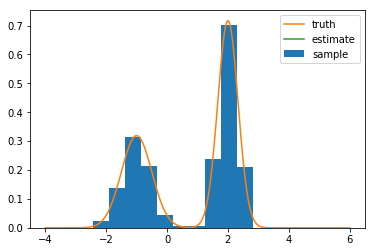

In [80]:
for i in range(10):
    P = E_step(z, θ)
    θ = M_step(P, θ, z, 100)
   
pl.hist(z, density = True, label = "sample");
plot_distr(π_true, μ_true, σ_true, interval = [-4, 6], label = "truth")
plot_distr(*get_πμσ(θ), interval =[-4, 6], label = "estimate")
pl.legend()

In [81]:
θ

(<tf.Variable 'rho:0' shape=(2,) dtype=float32, numpy=array([nan, nan], dtype=float32)>,
 <tf.Variable 'mu:0' shape=(2,) dtype=float32, numpy=array([nan, nan], dtype=float32)>,
 <tf.Variable 'beta:0' shape=(2,) dtype=float32, numpy=array([nan, nan], dtype=float32)>)